# Xử lý Text

In [3]:
import re, html, unicodedata
import pandas as pd
from tqdm import tqdm

INPUT_CSV = "P2_Youtube_VideosVI.csv"
OUT_CSV   = "stage1_desc_clean.csv"

# Options
USE_UNDERthesea = True     
DROP_STOPWORDS  = True
KEEP_NUMBERS    = True

try:
    import underthesea
    HAS_UNDER = True
except Exception:
    HAS_UNDER = False

# Regex
URL_RE    = re.compile(r"https?://\S+|www\.\S+")
EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
HTML_TAGS = re.compile(r"<[^>]+>")
PUNC_RE   = re.compile(r"[“”‘’\"'`.,;:!?(){}\[\]<>*#@~+=/\\|^$%]+")
KEEP_LATIN_VI = re.compile(r"[^0-9A-Za-zÀ-ỹ_\s]")

# Giữ hashtag, chuyển thành token `tag_*`
HASHTAG_RE = re.compile(r'(?<!\w)#([A-Za-z0-9_À-ỹ]+)', flags=re.UNICODE)

VN_STOPWORDS = {
    "và","hoặc","là","của","cho","các","những","một","được","trong","khi","với",
    "đã","sẽ","tại","theo","này","kia","đó","thì","như","về","đến","từ","rằng",
    "đi","lên","xuống","nữa","nhiều","ít","rất","hơi","tôi","mình","bạn","chúng",
    "này","kia","đấy","ấy","vậy","nhé","nhỉ"
}

def clean_desc(s: str) -> str:
    if not isinstance(s, str): return ""
    s = html.unescape(s)
    s = URL_RE.sub(" ", s)
    s = EMAIL_RE.sub(" ", s)
    s = HTML_TAGS.sub(" ", s)
    s = HASHTAG_RE.sub(lambda m: " tag_" + m.group(1).lower() + " ", s)
    s = s.lower()
    s = PUNC_RE.sub(" ", s)
    if not KEEP_NUMBERS:
        s = re.sub(r"\d+", " ", s)
    s = KEEP_LATIN_VI.sub(" ", s)
    s = re.sub(r"\s{2,}", " ", s).strip()
    if USE_UNDERthesea and HAS_UNDER:
        s = underthesea.word_tokenize(s, format="text")
    if DROP_STOPWORDS:
        s = " ".join(w for w in s.split() if w not in VN_STOPWORDS)
    return s

# --- RUN ---
df = pd.read_csv(INPUT_CSV, dtype=str)
df["description"] = df["description"].fillna("").apply(clean_desc)
df = df[df["description"].apply(lambda x: len(x) >= 30 and len(x.split()) >= 4)].reset_index(drop=True)
df = df[["video_id", "description"]]
df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("Saved:", OUT_CSV, "| Rows:", len(df))

Saved: stage1_desc_clean.csv | Rows: 7819


# Load SupSimCSE–PhoBERT model

In [28]:
from sentence_transformers import SentenceTransformer, models
import numpy as np, pandas as pd
from tqdm import tqdm

MODEL_PATH = r"C:\Users\DELL\.cache\huggingface\hub\models--VoVanPhuc--sup-SimCSE-VietNamese-phobert-base\snapshots\608779b86741a8acd8c8d38132974ff04086b138"
INPUT_CSV = "stage1_desc_clean.csv"
EMB_FILE  = "embeddings_desc_phobert.npy"

df = pd.read_csv(INPUT_CSV, dtype=str)
texts = df["description"].fillna("").tolist()

word_emb = models.Transformer(MODEL_PATH, max_seq_length=256)
pooling = models.Pooling(word_emb.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
normalize = models.Normalize()
model = SentenceTransformer(modules=[word_emb, pooling, normalize])

BATCH = 256
emb_list = []

for i in tqdm(range(0, len(texts), BATCH), desc="SupSimCSE encode"):
    emb_batch = model.encode(texts[i:i+BATCH], normalize_embeddings=True, show_progress_bar=False)
    emb_list.append(emb_batch)

emb = np.vstack(emb_list)
np.save(EMB_FILE, emb)
print(f"Saved: {EMB_FILE} | Shape: {emb.shape}")

SupSimCSE encode: 100%|████████████████████████████████████████████████████████████████| 31/31 [26:51<00:00, 51.99s/it]

Saved: embeddings_desc_phobert.npy | Shape: (7819, 768)


# Xây dựng mô hình BERTopic (sử dụng embedding SupSimCSE–PhoBERT)

In [4]:
from bertopic import BERTopic
import pandas as pd, numpy as np, umap, hdbscan

IN_CSV   = "stage1_desc_clean.csv"
EMB_FILE = "embeddings_desc_phobert.npy"
OUT_CSV  = "stage3_desc_bertopic.csv"

df = pd.read_csv(IN_CSV, dtype=str)
texts = df["description"].tolist()
emb = np.load(EMB_FILE)
print("Loaded embeddings:", emb.shape)

umap_model = umap.UMAP(n_neighbors=25, n_components=15, metric='cosine', random_state=42)
hdb_model = hdbscan.HDBSCAN(min_cluster_size=18, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    hdbscan_model=hdb_model,
    calculate_probabilities=True,
    min_topic_size=18,
    verbose=True
)

topics, probs = topic_model.fit_transform(texts, embeddings=emb)
df["topic_id"] = topics
df["topic_prob"] = np.max(probs, axis=1)

topic_model.reduce_topics(texts, nr_topics="auto")

topic_info = topic_model.get_topic_info()
topic_map = {row["Topic"]: row["Name"] for _, row in topic_info.iterrows()}
df["topic_name"] = df["topic_id"].map(topic_map)

df = df[df["topic_id"] != -1].copy()
df = df[["video_id", "description", "topic_id", "topic_name"]]

df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"Saved refined result: {OUT_CSV} | Topics detected: {df['topic_id'].nunique()}")
topic_model.save("bertopic_desc_supSimCSE_phobert")
print("BERTopic model saved: bertopic_desc_supSimCSE_phobert")

2025-10-14 22:43:29,033 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Loaded embeddings: (7819, 768)


2025-10-14 22:44:06,602 - BERTopic - Dimensionality - Completed ✓
2025-10-14 22:44:06,604 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-14 22:44:09,639 - BERTopic - Cluster - Completed ✓
2025-10-14 22:44:09,647 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-14 22:44:10,336 - BERTopic - Representation - Completed ✓
2025-10-14 22:44:10,861 - BERTopic - Topic reduction - Reducing number of topics
2025-10-14 22:44:10,881 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-14 22:44:11,504 - BERTopic - Representation - Completed ✓
2025-10-14 22:44:11,506 - BERTopic - Topic reduction - Reduced number of topics from 72 to 46
2025-10-14 22:44:11,960 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved refined result: stage3_desc_bertopic.csv | Topics detected: 71
BERTopic model saved: bertopic_desc_supSimCSE_phobert


In [5]:
# Xem nhanh 15 topic đầu
display(topic_model.get_topic_info().head(15))

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2712,-1_video_để_kênh_người,"[video, để, kênh, người, xem, không, đăng_ký, ...",[tag_tin tức 24 h_tag_tintuc toàn_cảnh tin_tức...
1,0,1734,0_bóng_đá_phim_kênh_việt_nam,"[bóng_đá, phim, kênh, việt_nam, hay, nhất, nhạ...",[chính_thức tv360 có bản_quyền champions_leagu...
2,1,360,1_điện_thoại_giá_sản_phẩm_vật_vờ,"[điện_thoại, giá, sản_phẩm, vật_vờ, iphone, mu...",[đánh_giá nhanh iphone 17 pro iphone 17 pro ma...
3,2,333,2_tin_tức_an_ninh_tin_mới,"[tin_tức, an_ninh, tin, mới, antv, nhất, 24, t...",[antv tin an_ninh trật_tự nóng mới nhất 24 h s...
4,3,312,3_khỏe_sức_sức_khỏe_bác_sĩ,"[khỏe, sức, sức_khỏe, bác_sĩ, bệnh, giúp, sống...",[mô_tả chung video bí_quyết giữ_gìn sức_khỏe t...
5,4,188,4_xe_đánh_giá_tipcar_tv,"[xe, đánh_giá, tipcar, tv, toyota, xehay, xe_m...",[đánh_giá volkswagen viloran mpv nhà giàu đúng...
6,5,176,5_ẩm_thực_khoai_đồng_quê_ăn,"[ẩm_thực, khoai, đồng_quê, ăn, ăn_uống, món, q...",[trận đấu quá khủng_khiếp người 200 k mua 7 mó...
7,6,171,6_tag_reviewphim_phim_review_tag_tomtatphim,"[tag_reviewphim, phim, review, tag_tomtatphim,...",[tag_reviewphim tag_tomtatphim tag_phimle tóm_...
8,7,167,7_du_lịch_tàu_biển_khám_phá,"[du_lịch, tàu, biển, khám_phá, nhật_ký, bãi, x...",[hè phải du_lịch biển chí_ít tìm địa_điểm du_l...
9,8,160,8_máy_tính_cách_hướng_dẫn_laptop,"[máy_tính, cách, hướng_dẫn, laptop, surface, w...",[hướng_dẫn cách kết_nối wifi máy_tính laptop k...


In [6]:
from bertopic import BERTopic
import pandas as pd

# Load mô hình và dữ liệu
topic_model = BERTopic.load("./bertopic_desc_supSimCSE_phobert/")
df = pd.read_csv("stage3_desc_bertopic.csv", dtype=str)
print("Loaded model & data:", len(df))

Loaded model & data: 5107


# Loại bỏ cụm -1 (noise)

In [8]:
# Loại bỏ các dòng có topic_id = -1 (noise)
clean_df = df[df["topic_id"] != -1].copy()

print("Removed noise:", len(df) - len(clean_df), "rows | Final:", len(clean_df))
print("\nTop 10 topics:")
print(clean_df["topic_name"].value_counts().head(10))

Removed noise: 0 rows | Final: 5107

Top 10 topics:
topic_name
0_bóng_đá_phim_kênh_việt_nam                            321
1_điện_thoại_giá_sản_phẩm_vật_vờ                        312
2_tin_tức_an_ninh_tin_mới                               275
3_khỏe_sức_sức_khỏe_bác_sĩ                              272
4_xe_đánh_giá_tipcar_tv                                 188
5_ẩm_thực_khoai_đồng_quê_ăn                             185
6_tag_reviewphim_phim_review_tag_tomtatphim             171
7_du_lịch_tàu_biển_khám_phá                             167
8_máy_tính_cách_hướng_dẫn_laptop                        160
10_đa_tầng_nóng_hổi_tag_kplussports_tag_ngoaihanganh    148
Name: count, dtype: int64


# Xem top từ khóa của cụm

In [9]:
topic_model.get_topic(1)

[('điện_thoại', np.float64(0.03293992885063342)),
 ('giá', np.float64(0.02694568483935517)),
 ('sản_phẩm', np.float64(0.025491086578221748)),
 ('vật_vờ', np.float64(0.02297878233356635)),
 ('iphone', np.float64(0.02223995788225809)),
 ('mua', np.float64(0.021665817470229703)),
 ('studio', np.float64(0.021398184397014866)),
 ('pro', np.float64(0.02048833780518794)),
 ('xiaomi', np.float64(0.019379543969474295)),
 ('đánh_giá', np.float64(0.01761446681640535))]

# Biểu đồ tần suất chủ đề và Intertopic Distance Map

In [10]:
from bertopic import BERTopic
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np, pandas as pd
from sklearn.metrics import silhouette_score
from IPython.display import display  

# --- Load model và data ---
topic_model = BERTopic.load("bertopic_desc_supSimCSE_phobert")
df = pd.read_csv("stage3_desc_bertopic.csv", dtype=str)

print("Final topics:", df["topic_id"].nunique(), "| Rows:", len(df))

# Visualization

# Biểu đồ tần suất (Top topic words)
fig_bar = topic_model.visualize_barchart(top_n_topics=20)
display(fig_bar)
fig_bar.write_html("topic_word_scores.html")
print("Saved: topic_word_scores.html")

# Biểu đồ UMAP 2D (Intertopic Distance Map)
fig_umap = topic_model.visualize_topics()
display(fig_umap)
fig_umap.write_html("intertopic_distance_map.html")
print("Saved: intertopic_distance_map.html")

# Evaluate cluster quality
emb = np.load("embeddings_desc_phobert.npy")
labels = topic_model.hdbscan_model.labels_
mask = labels != -1
score = silhouette_score(emb[mask], labels[mask]) if len(set(labels[mask])) > 1 else np.nan
print("Silhouette (HDBSCAN):", round(score, 4))

Final topics: 71 | Rows: 5107


Saved: topic_word_scores.html


Saved: intertopic_distance_map.html
Silhouette (HDBSCAN): 0.1118


- Nhận xét Biểu đồ tần suất chủ đề (Topic Word Scores):

    - Các chủ đề thể hiện tính đa dạng và tách biệt rõ: giải trí, công nghệ, sức khỏe, ẩm thực, du lịch, học tập…

    - Ít trùng lặp từ khóa giữa các topic cho thấy mô hình BERTopic kết hợp HDBSCAN đã gom nhóm ngữ nghĩa tốt.

- Nhận xét Biểu đồ khoảng cách chủ đề (Intertopic Distance Map):

    - Các cụm chủ đề phân bố khá tách biệt, chỉ một vài cụm nằm gần nhau cho thấy có mối liên hệ ngữ nghĩa nhẹ giữa các nhóm nội dung.

    - Vùng trung tâm tập trung nhiều cụm nhỏ phản ánh các chủ đề phổ biến hoặc có nội dung chồng lấn.

    - Một số cụm nằm tách rời hoàn toàn, thể hiện tính đặc trưng cao của các nhóm.

=> Biểu đồ cho thấy mô hình BERTopic với SupSimCSE–PhoBERT đã tách được ranh giới ngữ nghĩa rõ ràng giữa các nhóm nội dung, đồng thời vẫn bảo toàn quan hệ gần–xa hợp lý trong không gian chủ đề.

# Trực quan hóa HDBSCAN

HDBSCAN info:
Số điểm dữ liệu: 7819
Số cụm: 71


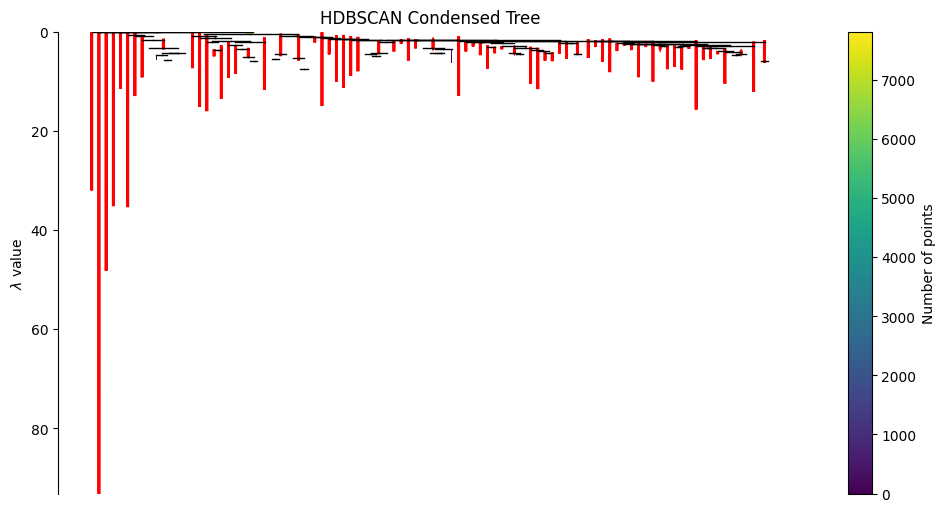

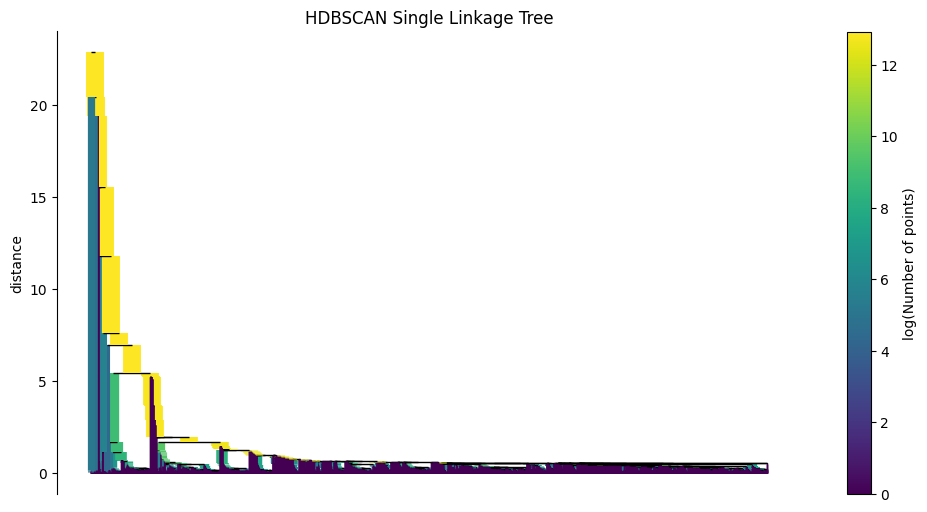

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Kiểm tra mô hình
hdb = topic_model.hdbscan_model

print("HDBSCAN info:")
print("Số điểm dữ liệu:", len(hdb.labels_))
print("Số cụm:", len(set(hdb.labels_)) - (1 if -1 in hdb.labels_ else 0))

# Cây cô đọng (Condensed Tree)
plt.figure(figsize=(12, 6))
hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette("deep", 10))
plt.title("HDBSCAN Condensed Tree")
plt.show()

# Cây liên kết đơn (Single Linkage Tree)
plt.figure(figsize=(12, 6))
hdb.single_linkage_tree_.plot()
plt.title("HDBSCAN Single Linkage Tree")
plt.show()

- Nhận xét biểu đồ HDBSCAN Condensed Tree:

    - Cây cô đọng thể hiện 71 cụm chủ đề chính được HDBSCAN phát hiện từ 7.819 điểm dữ liệu, trong đó nhiều nhánh dài thể hiện các cụm lớn, ổn định.

    - Các đoạn đỏ cho thấy ranh giới phân tách rõ ràng giữa các cụm. Mô hình đã tìm ra ngưỡng mật độ phù hợp để loại bỏ nhiễu.

    - Một số nhánh ngắn và cụm nhỏ xuất hiện rải rác, phản ánh sự tồn tại của các nhóm nội dung ít phổ biến hoặc có tính ngữ nghĩa riêng biệt.

    - Việc hình thành nhiều cụm nhỏ nhưng phân tách rõ cho thấy mô hình HDBSCAN hoạt động tốt trên embedding SupSimCSE–PhoBERT, giúp nhận diện chi tiết cấu trúc chủ đề trong tập video.

- Nhận xét biểu đồ HDBSCAN Single Linkage Tree:

    - Biểu đồ cho thấy phần lớn điểm dữ liệu được gom ở vùng khoảng cách nhỏ (~5), chứng tỏ các điểm có mật độ cao và độ tương đồng lớn.

    - Các nhánh cao hơn biểu thị một số cụm tách biệt rõ ràng, tương ứng với những chủ đề có ngữ nghĩa khác biệt.

    - Màu sắc biểu thị kích thước cụm, trong đó các đoạn có màu vàng đại diện cho các cụm lớn, ổn định.

    - Nhìn chung, biểu đồ này xác nhận rằng mô hình HDBSCAN đã tìm được cấu trúc phân cụm hợp lý, với mật độ cao ở lõi và một số cụm riêng biệt ở rìa, phản ánh tính đa dạng tự nhiên của dữ liệu video mô tả.

# So sánh với K-MEANS VÀ DBSCAN

KMeans(k=10): inertia=2.17e+03 | silhouette=0.0705
KMeans(k=20): inertia=1.91e+03 | silhouette=0.0994
KMeans(k=30): inertia=1.78e+03 | silhouette=0.1010
KMeans(k=40): inertia=1.69e+03 | silhouette=0.1139
KMeans(k=50): inertia=1.62e+03 | silhouette=0.1168
KMeans(k=60): inertia=1.57e+03 | silhouette=0.1205
KMeans(k=70): inertia=1.52e+03 | silhouette=0.1287
KMeans(k=80): inertia=1.48e+03 | silhouette=0.1343
KMeans(k=90): inertia=1.44e+03 | silhouette=0.1324
KMeans(k=100): inertia=1.41e+03 | silhouette=0.1378


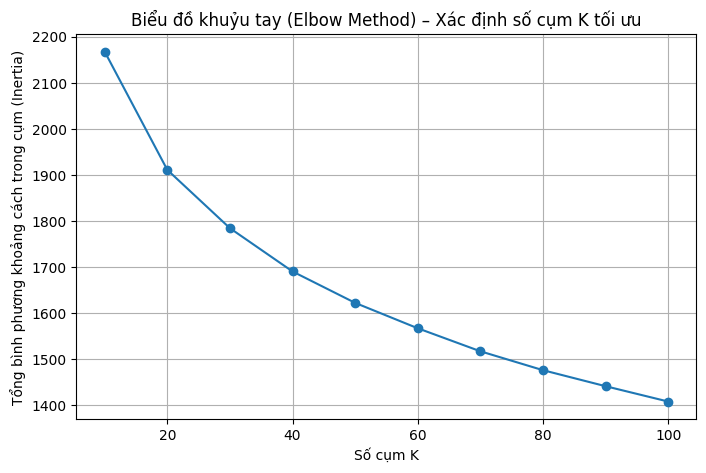

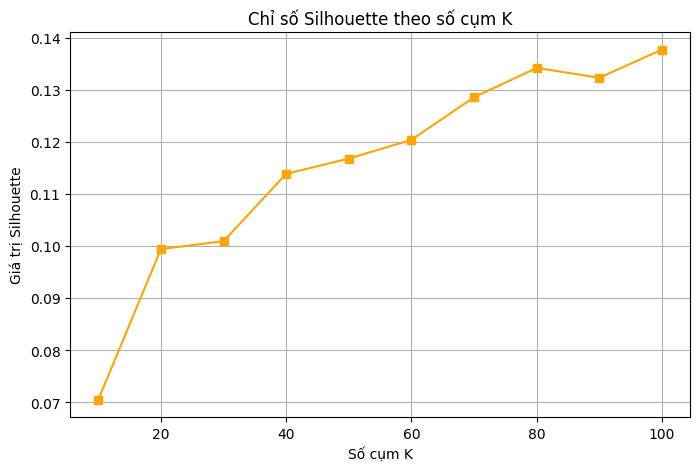


Best K: 100 (silhouette=0.1378)
KMeans clusters: 100
DBSCAN clusters: 3 | noise: 8.24%
HDBSCAN clusters (sau khi loại nhiễu): 71
HDBSCAN silhouette: 0.1118


In [20]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

mask = topic_model.hdbscan_model.labels_ != -1
X = emb[mask]

# Tìm số cụm K tối ưu cho KMeans
sil_scores = {}
inertias = {}
K_range = range(10, 101, 10)  # Dò từ 10 đến 100 cụm

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertias[k] = km.inertia_
    score = silhouette_score(X, labels)
    sil_scores[k] = score
    print(f"KMeans(k={k}): inertia={km.inertia_:.2e} | silhouette={score:.4f}")

# Trực quan hóa Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(list(inertias.keys()), list(inertias.values()), marker='o')
plt.title("Biểu đồ khuỷu tay (Elbow Method) – Xác định số cụm K tối ưu")
plt.xlabel("Số cụm K")
plt.ylabel("Tổng bình phương khoảng cách trong cụm (Inertia)")
plt.grid(True)
plt.show()

# Trực quan hóa Silhouette
plt.figure(figsize=(8, 5))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='s', color='orange')
plt.title("Chỉ số Silhouette theo số cụm K")
plt.xlabel("Số cụm K")
plt.ylabel("Giá trị Silhouette")
plt.grid(True)
plt.show()

# Tìm K tốt nhất
best_k = max(sil_scores, key=sil_scores.get)
best_score = sil_scores[best_k]
print(f"\nBest K: {best_k} (silhouette={best_score:.4f})")

# Huấn luyện lại với K tối ưu
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
km_labels = km_final.fit_predict(X)
print(f"KMeans clusters: {len(set(km_labels))}")

# DBSCAN baseline
db = DBSCAN(eps=0.3, min_samples=10, metric='cosine')
db_labels = db.fit_predict(X)
db_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
db_noise = np.mean(db_labels == -1)
print(f"DBSCAN clusters: {db_clusters} | noise: {db_noise:.2%}")

# HDBSCAN (sau khi loại nhiễu, dùng cho so sánh công bằng)
hd_labels_full = topic_model.hdbscan_model.labels_
mask = hd_labels_full != -1
hd_labels = hd_labels_full[mask]
X = emb[mask]

hd_clusters = len(set(hd_labels))
hd_noise = float(np.mean(hd_labels_full == -1))
print(f"HDBSCAN clusters (sau khi loại nhiễu): {hd_clusters}")

# So sánh chất lượng bằng Silhouette
if len(set(hd_labels)) > 1:
    hd_score = silhouette_score(X, hd_labels)
else:
    hd_score = np.nan
print(f"HDBSCAN silhouette: {hd_score:.4f}")

# Agglomerative Clustering

=== Agglomerative Clustering (Hierarchical) ===
Agglomerative Clustering: 26 cụm

=== Dendrogram trực quan cấu trúc phân cấp ===


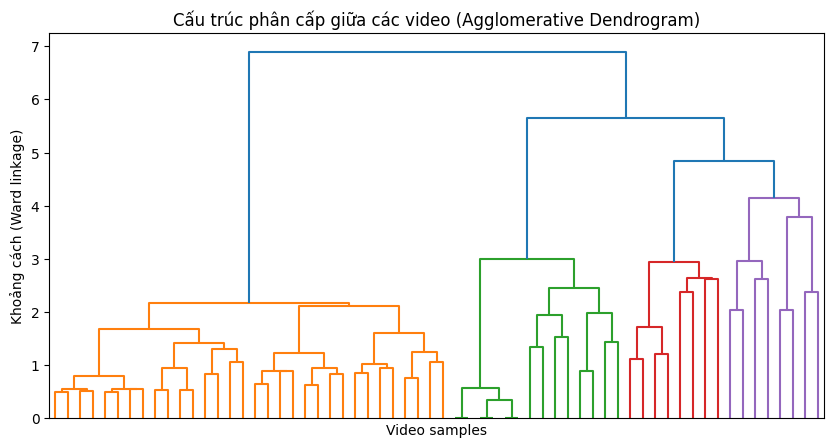


=== BERTopic Hierarchical Topics ===


100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 268.29it/s]


Saved interactive map: hierarchical_topics.html


In [18]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from bertopic import BERTopic

# Agglomerative Clustering
print("=== Agglomerative Clustering (Hierarchical) ===")
agg = AgglomerativeClustering(
    distance_threshold=5.0,   # ngưỡng cắt để xác định cụm
    n_clusters=None,          # dùng số cụm tốt nhất từ KMeans        
    linkage='ward'            # phương pháp liên kết Ward 
)

agg_labels = agg.fit_predict(X)
agg_score = silhouette_score(X, agg_labels)
print(f"Agglomerative Clustering: {len(set(agg_labels))} cụm")

# Vẽ dendrogram (500 điểm đầu)
print("\n=== Dendrogram trực quan cấu trúc phân cấp ===")
Z = linkage(X[:500], method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5, no_labels=True)
plt.title("Cấu trúc phân cấp giữa các video (Agglomerative Dendrogram)")
plt.xlabel("Video samples")
plt.ylabel("Khoảng cách (Ward linkage)")
plt.show()

# Tạo và trực quan hóa cây chủ đề phân cấp bằng BERTopic
print("\n=== BERTopic Hierarchical Topics ===")
full_texts = pd.read_csv("stage1_desc_clean.csv", dtype=str)["description"].fillna("").tolist()

hier_topics = topic_model.hierarchical_topics(full_texts)
fig_hier = topic_model.visualize_hierarchy()

fig_hier.write_html("hierarchical_topics.html")
print("Saved interactive map: hierarchical_topics.html")
fig_hier.show()


- Biểu đồ Cấu trúc phân cấp giữa các video (Agglomerative Dendrogram)

    - Biểu đồ này được tạo từ Agglomerative Clustering áp dụng trên embedding SupSimCSE–PhoBERT (768 chiều), với phương pháp Ward linkage.

    - Các nhánh màu thể hiện mức độ tương đồng ngữ nghĩa giữa các video: những video hợp nhất ở khoảng cách nhỏ (dưới 1.0) có nội dung tương tự.

    - Những nhánh ở phần trên (khoảng cách >3.0) biểu thị sự khác biệt rõ rệt giữa các nhóm video, phản ánh sự đa dạng nội dung trong tập mô tả YouTube.

- Biểu đồ Hierarchical Clustering 

    - Biểu đồ này trực quan hóa cùng cấu trúc phân cấp, nhưng có hiển thị nhãn chủ đề thực tế.

    - Các video có tag hoặc từ khóa tương tự được gom ở các nhánh thấp (≈0.5–1.0), cho thấy embedding SupSimCSE–PhoBERT đã nắm bắt tốt ngữ nghĩa văn bản mô tả.

    - Những nhóm hợp nhất ở mức cao hơn đại diện cho các nhóm chủ đề lớn hơn.

=> Mô hình này được sử dụng như một công cụ trực quan bổ trợ, giúp thể hiện sự phân cấp ngữ nghĩa và mối quan hệ giữa các nhóm chủ đề.

In [21]:
print("\nSo sánh tổng hợp:")
print(f"KMeans:   {best_k} cụm | silhouette={best_score:.4f}")
print(f"DBSCAN:   {db_clusters} cụm | noise={db_noise:.2%}")
print(f"HDBSCAN:  {hd_clusters} cụm | noise={hd_noise:.2%} | silhouette={hd_score:.4f}")


So sánh tổng hợp:
KMeans:   100 cụm | silhouette=0.1378
DBSCAN:   3 cụm | noise=8.24%
HDBSCAN:  71 cụm | noise=34.68% | silhouette=0.1118


- Nhận xét kết quả so sánh mô hình phân cụm:

    - KMeans (100 cụm, silhoutte = 0.1378) đạt giá trị silhoutte cao nhất. Tuy chia được nhiều nhóm nhưng độ gắn kết giữa các điểm chưa cao. Sẽ phù hợp nếu dữ liệu có biên cụm rõ ràng hơn.

    - DBSCAN (3 cụm, noise 8.24%) chỉ tạo được ít nhóm, phản ánh việc tham số eps chưa bắt được mật độ thực tế của dữ liệu ngữ nghĩa, tuy ít nhiễu hơn nhưng mất tính chi tiết.

    - HDBSCAN (71 cụm, noise 34.7%) tạo số cụm tương đối sát với cấu trúc tự nhiên, tách biệt tốt hơn (silhouette ≈ 0.1118) dù chấp nhận một phần nhiễu cho thấy khả năng thích ứng với mật độ biến thiên của dữ liệu văn bản.

=> Tổng thể, HDBSCAN kết hợp với embedding SupSimCSE–PhoBERT đạt hiệu quả phân cụm cao nhất, thể hiện được sự đa dạng và phân bố ngữ nghĩa tự nhiên trong tập mô tả video YouTube. Trong khi đó, Agglomerative Clustering bổ sung góc nhìn trực quan và phân cấp, giúp giải thích mối quan hệ chủ đề, đóng vai trò mô hình đối chứng hữu ích trong phân tích kết quả.